<a href="https://colab.research.google.com/github/gtsagkatakis/Data-Science-and-Applications/blob/main/CSD458_HW6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load Dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.vector_ar.var_model import VAR

# Load dataset
from statsmodels.datasets import sunspots
df = sunspots.load_pandas().data

#ADF Analysis

##is stationary?




# ACF & PACF


#STL Analysis

#ARIMA Model
## p=? , why
## q=?, why
## d=?, why

#LSTM Model

#Simple RNN

#Plot Actual and Predicted values from all models

#Plot Performance metric for each method

     YEAR  SUNACTIVITY
0  1700.0          5.0
1  1701.0         11.0
2  1702.0         16.0
3  1703.0         23.0
4  1704.0         36.0


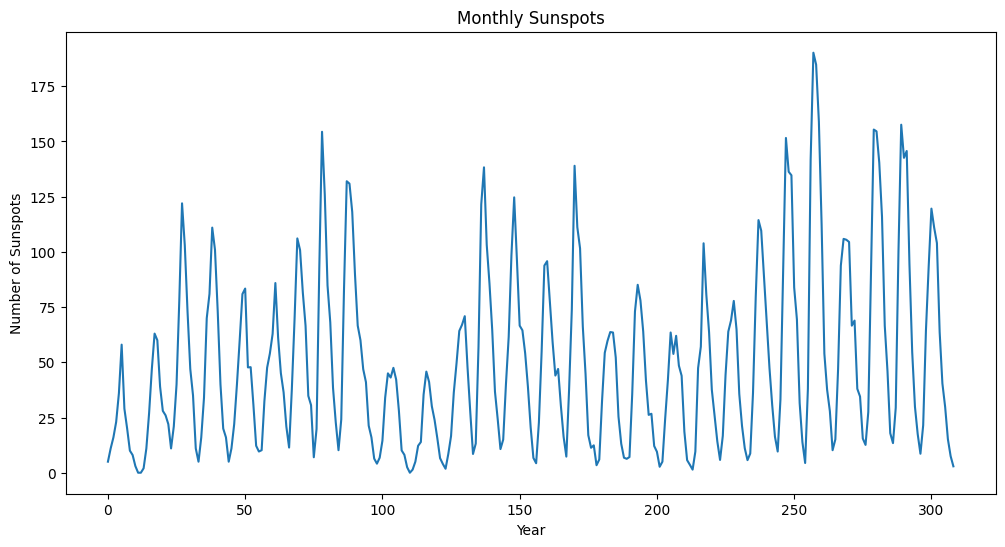

ADF Statistic: -2.8377807249381943
p-value: 0.053076421728120673
Critical Values:
	1%: -3.4523371197407404
	5%: -2.871222860740741
	10%: -2.571929211111111


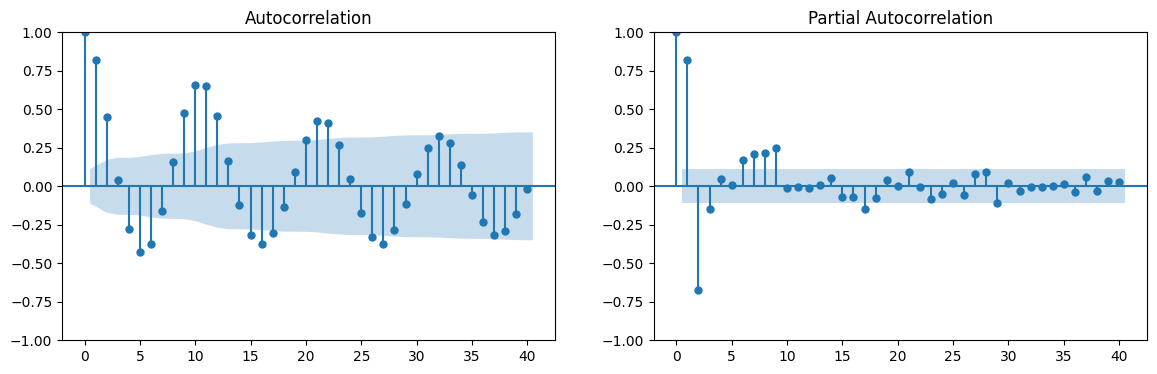

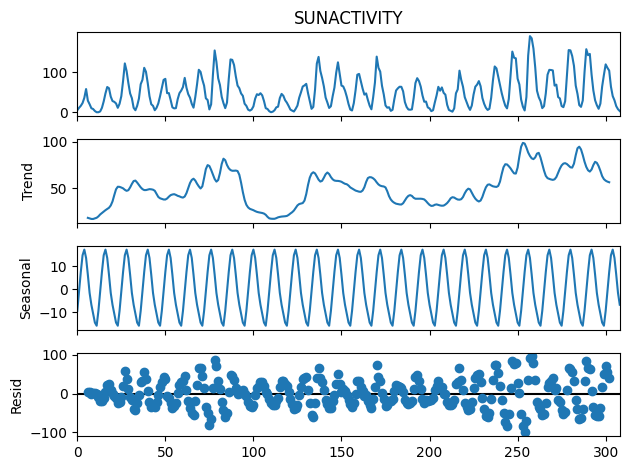

2/2 [==============================] - 0s 8ms/step
ARIMA Mean Squared Error: 1789.090318880584
LSTM Mean Squared Error: 362.617410165793
Simple RNN Mean Squared Error: 290.41122896807843


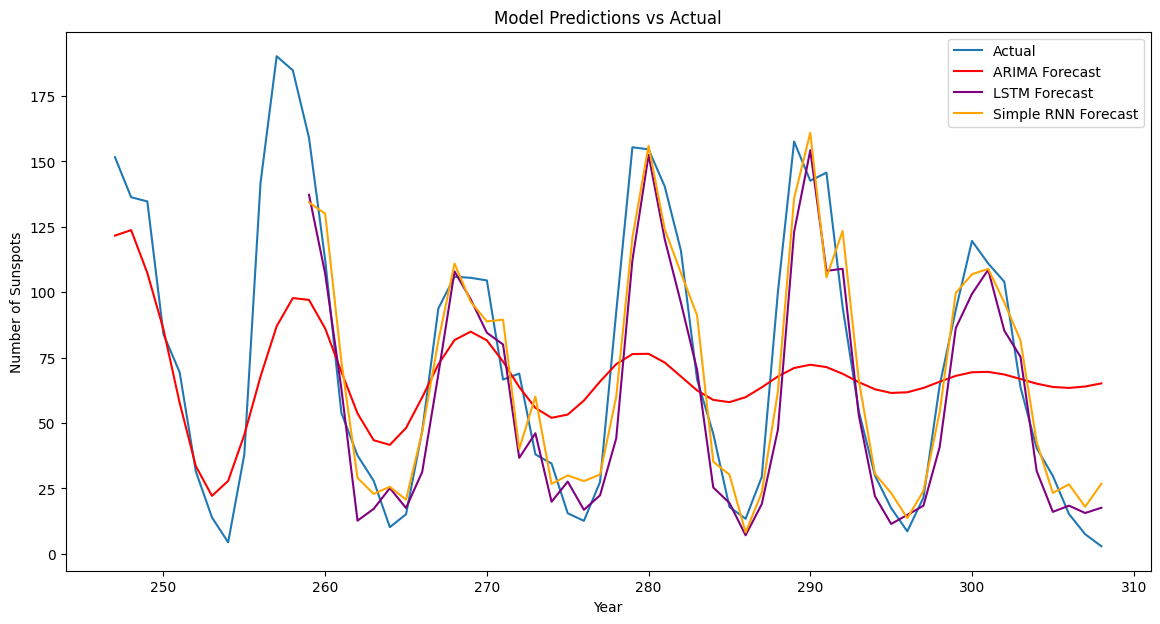

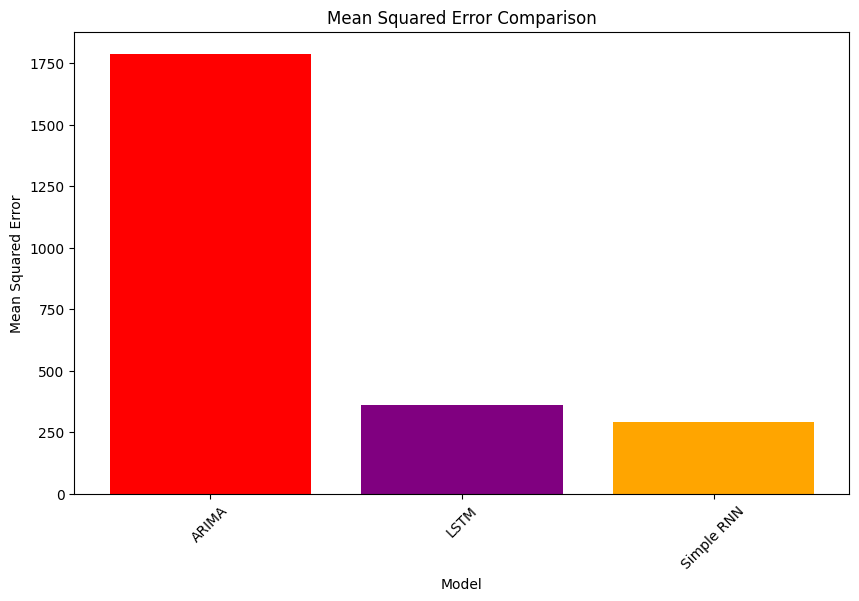

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.vector_ar.var_model import VAR

# Load dataset
from statsmodels.datasets import sunspots
df = sunspots.load_pandas().data

# Take a look at the first few rows of the dataset
print(df.head())

# Select only one column (SUNACTIVITY) for modeling
df = df[['SUNACTIVITY']]

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(df)
plt.title('Monthly Sunspots')
plt.xlabel('Year')
plt.ylabel('Number of Sunspots')
plt.show()

# Perform ADF test for stationarity
def adf_test(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

adf_test(df['SUNACTIVITY'])

# Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(df['SUNACTIVITY'], lags=40, ax=ax1)
plot_pacf(df['SUNACTIVITY'], lags=40, ax=ax2)
plt.show()

# Seasonal decomposition
decomposition = seasonal_decompose(df['SUNACTIVITY'], model='additive', period=12)
decomposition.plot()
plt.show()

# Train-test split
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Train ARIMA model
arima_model = ARIMA(train, order=(5, 1, 1))
arima_fitted_model = arima_model.fit()
arima_forecast = arima_fitted_model.forecast(steps=len(test))

# Train LSTM model
scaler = MinMaxScaler(feature_range=(0, 1))
train_normalized = scaler.fit_transform(train)
test_normalized = scaler.transform(test)

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 12
X_train, y_train = create_dataset(train_normalized, train_normalized, time_steps)
X_test, y_test = create_dataset(test_normalized, test_normalized, time_steps)

lstm_model = Sequential()
lstm_model.add(LSTM(units=50, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(Dense(units=1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

lstm_forecast = lstm_model.predict(X_test)
lstm_forecast = scaler.inverse_transform(lstm_forecast)

# Train Simple RNN model
rnn_model = Sequential()
rnn_model.add(SimpleRNN(units=50, input_shape=(X_train.shape[1], X_train.shape[2])))
rnn_model.add(Dense(units=1))
rnn_model.compile(optimizer='adam', loss='mean_squared_error')
rnn_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

rnn_forecast = rnn_model.predict(X_test)
rnn_forecast = scaler.inverse_transform(rnn_forecast)

# Train VAR model
#var_model = VAR(train)
##var_fitted_model = var_model.fit()
#var_forecast = var_fitted_model.forecast(train.values[-12:], steps=len(test))

# Evaluate ARIMA model
arima_mse = mean_squared_error(test, arima_forecast)
print('ARIMA Mean Squared Error:', arima_mse)

# Evaluate LSTM model
lstm_mse = mean_squared_error(test[time_steps:], lstm_forecast)
print('LSTM Mean Squared Error:', lstm_mse)

# Evaluate Simple RNN model
rnn_mse = mean_squared_error(test[time_steps:], rnn_forecast)
print('Simple RNN Mean Squared Error:', rnn_mse)

# Evaluate VAR model
#var_mse = mean_squared_error(test, var_forecast)
#print('VAR Mean Squared Error:', var_mse)

# Plot predictions
plt.figure(figsize=(14, 7))
plt.plot(test, label='Actual')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='red')
plt.plot(test.index[time_steps:], lstm_forecast, label='LSTM Forecast', color='purple')
plt.plot(test.index[time_steps:], rnn_forecast, label='Simple RNN Forecast', color='orange')
#plt.plot(test.index, var_forecast, label='VAR Forecast', color='green')
plt.legend()
plt.title('Model Predictions vs Actual')
plt.xlabel('Year')
plt.ylabel('Number of Sunspots')
plt.show()

# Bar plot for comparing MSE
models = ['ARIMA', 'LSTM', 'Simple RNN']
mse_values = [arima_mse, lstm_mse, rnn_mse]

plt.figure(figsize=(10, 6))
plt.bar(models, mse_values, color=['red', 'purple', 'orange', 'green'])
plt.title('Mean Squared Error Comparison')
plt.xlabel('Model')
plt.ylabel('Mean Squared Error')
plt.xticks(rotation=45)
plt.show()
